# **Uber Ride Sharing Demand and Rider Behavior Analytics**

## Executive Overview
- Purpose: analyze 2014-2015 NYC Uber pickups to surface demand patterns and operational levers.
- Methods: descriptive EDA, temporal profiling, linear regression on time features, spatial clustering with K tuning.
- Outputs: charts for base performance and intraday demand, regression diagnostics, hotspot maps, and month-over-month cluster comparisons.

## Data Sources & Assumptions
- Inputs: Uber pickup CSVs for 2014-2015 with Base IDs, timestamps, and geolocation.
- Context: notebooks reuse class-prepared data under `Data/`.
- Environment: expect pandas/numpy/matplotlib/seaborn/folium/sklearn/statsmodels available; adjust paths if running locally.



---



# **1.Data Loading & Preparation**

In [ ]:
import os
import os.path
import time
import warnings
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/Projects/Uber'

In [ ]:
uber_2014_pickup_data = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2014', 'uber-raw-data-2014.csv'))

uber_2014_pickup_data['Date/Time'] = pd.to_datetime(uber_2014_pickup_data['Date/Time'], format='mixed')
uber_2014_pickup_data['Date'] = pd.to_datetime(uber_2014_pickup_data['Date'])


In [ ]:
uber_2015_pickup_data = pd.read_csv(os.path.join(data_path, 'Uber_Trip_Data_2015', 'uber-raw-data-janjune-15.csv'))

uber_2015_pickup_data['Date'] = pd.to_datetime(uber_2015_pickup_data['Pickup_date']).dt.date

In [ ]:
uber_2014_pickup_data['Month'] = uber_2014_pickup_data['Date/Time'].dt.month

uber_2014_pickup_data['Week'] = uber_2014_pickup_data['Date/Time'].dt.isocalendar().week

uber_2014_pickup_data['DayOfMonthNum'] = uber_2014_pickup_data['Date/Time'].dt.day

uber_2014_pickup_data['DayOfWeekNum'] = uber_2014_pickup_data['Date/Time'].dt.dayofweek

uber_2014_pickup_data['DayOfWeek'] = uber_2014_pickup_data['Date/Time'].dt.day_name()

uber_2014_pickup_data['Hour'] = uber_2014_pickup_data['Date/Time'].dt.hour

In [ ]:
uber_2014_pickup_data.head()

,Date/Time,Lat,Lon,Base,Date,Time,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,00:11:00,4,14,1,1,Tuesday,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,00:17:00,4,14,1,1,Tuesday,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,00:21:00,4,14,1,1,Tuesday,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,00:28:00,4,14,1,1,Tuesday,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,00:33:00,4,14,1,1,Tuesday,0


In [ ]:
def add_date_features(df, datetime_column):
    # Ensure the datetime_column is in datetime format
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Add date features
    df['Month'] = df[datetime_column].dt.month
    df['Week'] = df[datetime_column].dt.isocalendar().week
    df['DayOfMonthNum'] = df[datetime_column].dt.day
    df['DayOfWeekNum'] = df[datetime_column].dt.dayofweek
    df['DayOfWeek'] = df[datetime_column].dt.day_name()
    df['Hour'] = df[datetime_column].dt.hour

    return df

In [ ]:
uber_2015_pickup_data = add_date_features(uber_2015_pickup_data, 'Pickup_date')

uber_2015_pickup_data.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Date,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,B02617,2015-05-17 09:47:00,B02617,141,2015-05-17,5,20,17,6,Sunday,9
1,B02617,2015-05-17 09:47:00,B02617,65,2015-05-17,5,20,17,6,Sunday,9
2,B02617,2015-05-17 09:47:00,B02617,100,2015-05-17,5,20,17,6,Sunday,9
3,B02617,2015-05-17 09:47:00,B02774,80,2015-05-17,5,20,17,6,Sunday,9
4,B02617,2015-05-17 09:47:00,B02617,90,2015-05-17,5,20,17,6,Sunday,9


# **2.Exploratory Data Analysis (EDA)**

# **3.Base-Level Demand Analysis (2014)**


##3.1 Total Trips by Base (Counts + Ranking)

Quantify which bases account for the most pickups and how concentrated demand is across bases.

In [ ]:
trips_per_base = uber_2014_pickup_data.groupby('Base')['Base'].count().reset_index(name='TripCount')

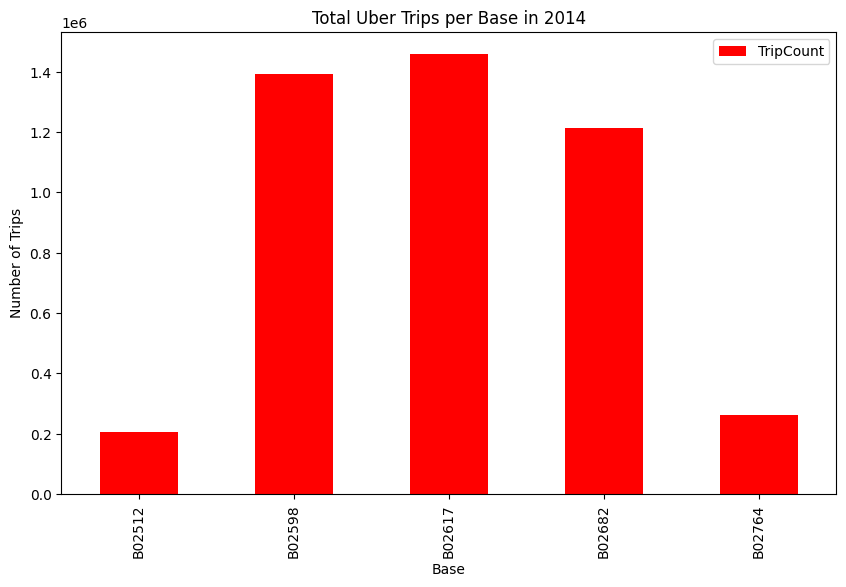

In [ ]:
trips_per_base.set_index('Base').plot(kind='bar', figsize=(10,6), color = 'red')
plt.title('Total Uber Trips per Base in 2014')
plt.xlabel('Base')
plt.ylabel('Number of Trips')
plt.show()

## 3.2 Base Activity Over Time (Trend)

Track base-level demand over time to reveal growth, decline, or volatility.

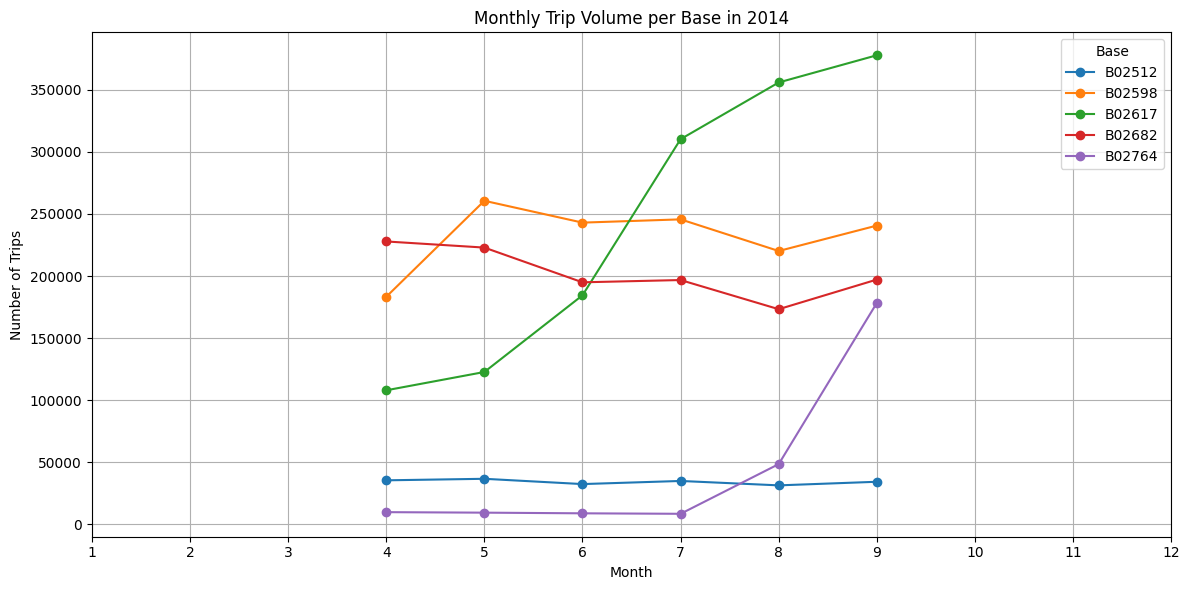

In [ ]:
monthly_trips_per_base = uber_2014_pickup_data.groupby(['Base', 'Month'])['Base'].count().reset_index(name='TripCount')

bases = uber_2014_pickup_data['Base'].unique()

plt.figure(figsize=(12,6))

for base in bases:
    base_data = monthly_trips_per_base[monthly_trips_per_base['Base'] == base]
    plt.plot(base_data['Month'], base_data['TripCount'], marker='o', label=base)

plt.title('Monthly Trip Volume per Base in 2014')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.legend(title='Base')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3 Weekday vs Weekend Mix by Base

Compare weekday/weekend composition to identify commuter-heavy vs leisure-heavy bases.

In [ ]:
uber_2014_pickup_data['Base'].unique()

array(['B02512', 'B02598', 'B02617', 'B02682', 'B02764'], dtype=object)

In [ ]:
uber_2014_pickup_data

,Date/Time,Lat,Lon,Base,Date,Time,Month,Week,DayOfMonthNum,DayOfWeekNum,DayOfWeek,Hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,00:11:00,4,14,1,1,Tuesday,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,00:17:00,4,14,1,1,Tuesday,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,00:21:00,4,14,1,1,Tuesday,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,00:28:00,4,14,1,1,Tuesday,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,00:33:00,4,14,1,1,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4534322,2014-09-30 22:57:00,40.7668,-73.9845,B02764,2014-09-30,22:57:00,9,40,30,1,Tuesday,22
4534323,2014-09-30 22:57:00,40.6911,-74.1773,B02764,2014-09-30,22:57:00,9,40,30,1,Tuesday,22
4534324,2014-09-30 22:58:00,40.8519,-73.9319,B02764,2014-09-30,22:58:00,9,40,30,1,Tuesday,22
4534325,2014-09-30 22:58:00,40.7081,-74.0066,B02764,2014-09-30,22:58:00,9,40,30,1,Tuesday,22


In [ ]:
#step 1 - find weekday vs weekend
uber_2014_pickup_data['DayType'] = np.where(
    uber_2014_pickup_data['DayOfWeek'].isin(['Saturday', 'Sunday']),
    'Weekend',
    'Weekday'
)

uber_2014_pickup_data['DayType'].unique()

array(['Weekday', 'Weekend'], dtype=object)

In [ ]:
total_trips = uber_2014_pickup_data.groupby(['Base', 'DayType'])['Base'].count().reset_index(name='TripCount')

total_trips

,Base,DayType,TripCount
0,B02512,Weekday,158410
1,B02512,Weekend,47263
2,B02598,Weekday,1047629
3,B02598,Weekend,345484
4,B02617,Weekday,1087847
5,B02617,Weekend,371006
6,B02682,Weekday,916118
7,B02682,Weekend,296671
8,B02764,Weekday,188029
9,B02764,Weekend,75870


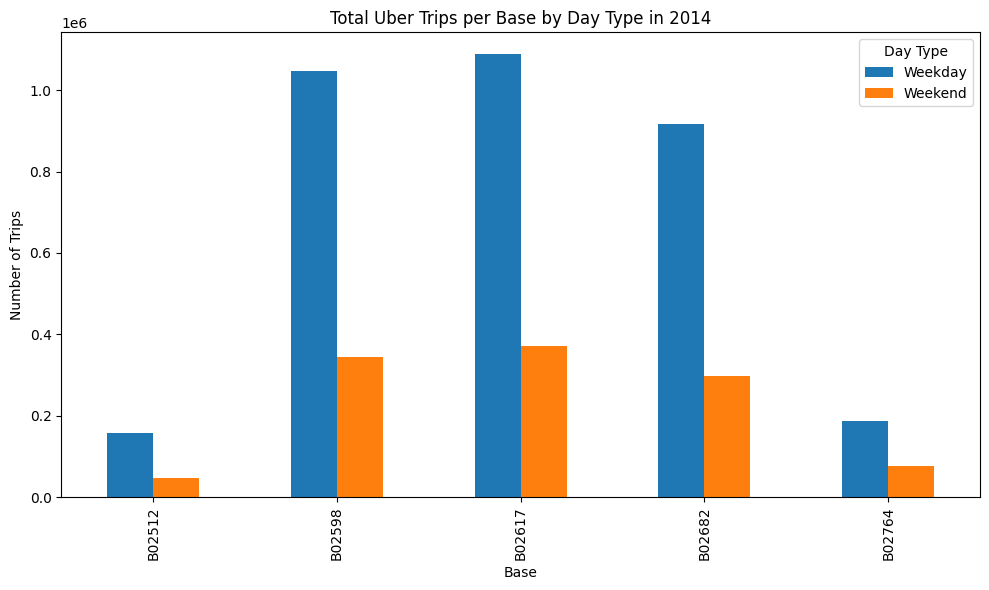

In [ ]:
total_trips.set_index(['Base', 'DayType']).unstack().plot(kind = 'bar', figsize = (10,6))

plt.title('Total Uber Trips per Base by Day Type in 2014')
plt.xlabel('Base')
plt.ylabel('Number of Trips')
plt.legend(title='Day Type', labels=['Weekday', 'Weekend'])
plt.tight_layout()
plt.show()

# **4. Temporal Demand Patterns (2014)**

## 4.1 Hourly Trip Patterns by Base × Day-of-Week

Visualize hourly curves split by day-of-week to reveal commute peaks and nightlife behavior.

In [ ]:
hourly_trips = uber_2014_pickup_data.groupby(['Base', 'DayOfWeek', 'Hour'])['Base'].count().reset_index(name='TripCount')
hourly_trips

,Base,DayOfWeek,Hour,TripCount
0,B02512,Friday,0,473
1,B02512,Friday,1,276
2,B02512,Friday,2,197
3,B02512,Friday,3,242
4,B02512,Friday,4,300
...,...,...,...,...
835,B02764,Wednesday,19,2427
836,B02764,Wednesday,20,2335
837,B02764,Wednesday,21,2030
838,B02764,Wednesday,22,1532


In [ ]:
hourly_trips['DayOfWeek']

,DayOfWeek
0,Friday
1,Friday
2,Friday
3,Friday
4,Friday
...,...
835,Wednesday
836,Wednesday
837,Wednesday
838,Wednesday


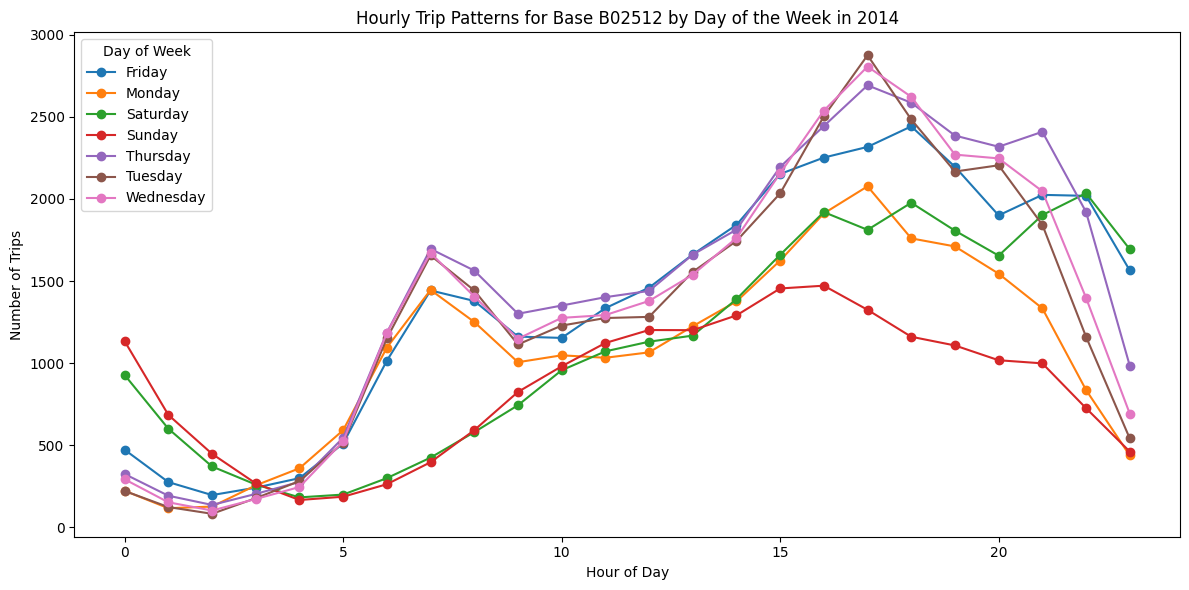

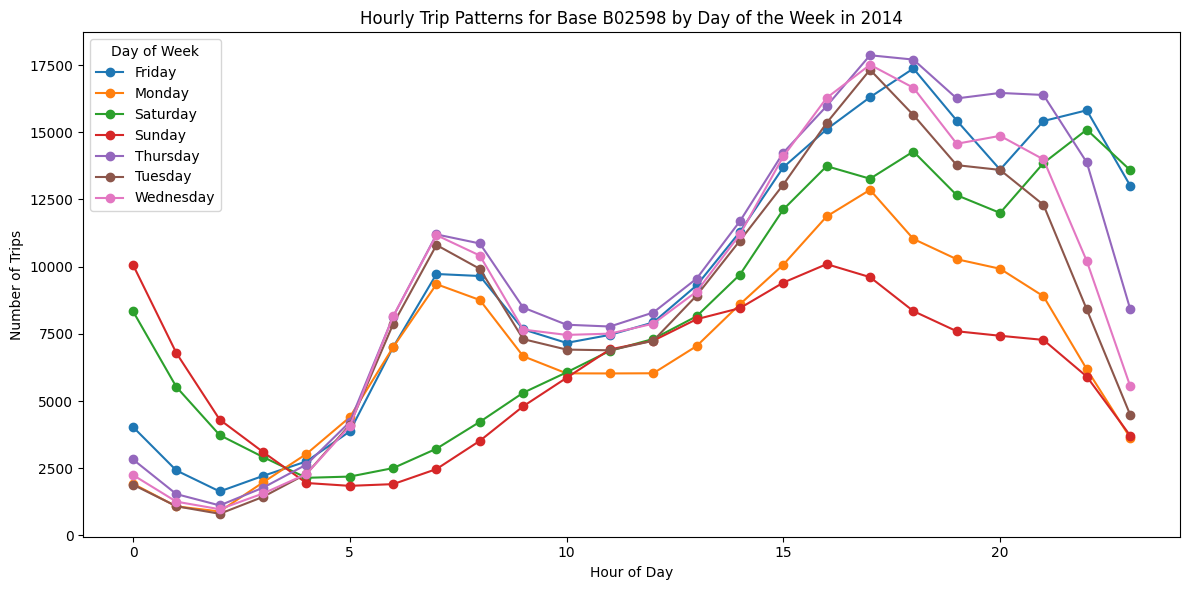

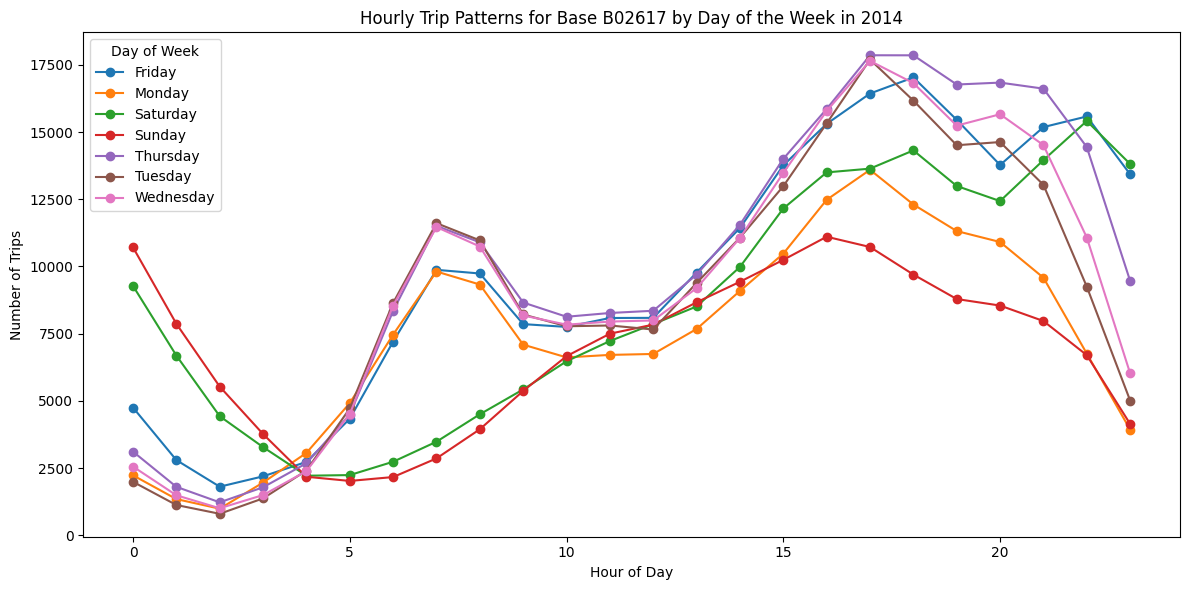

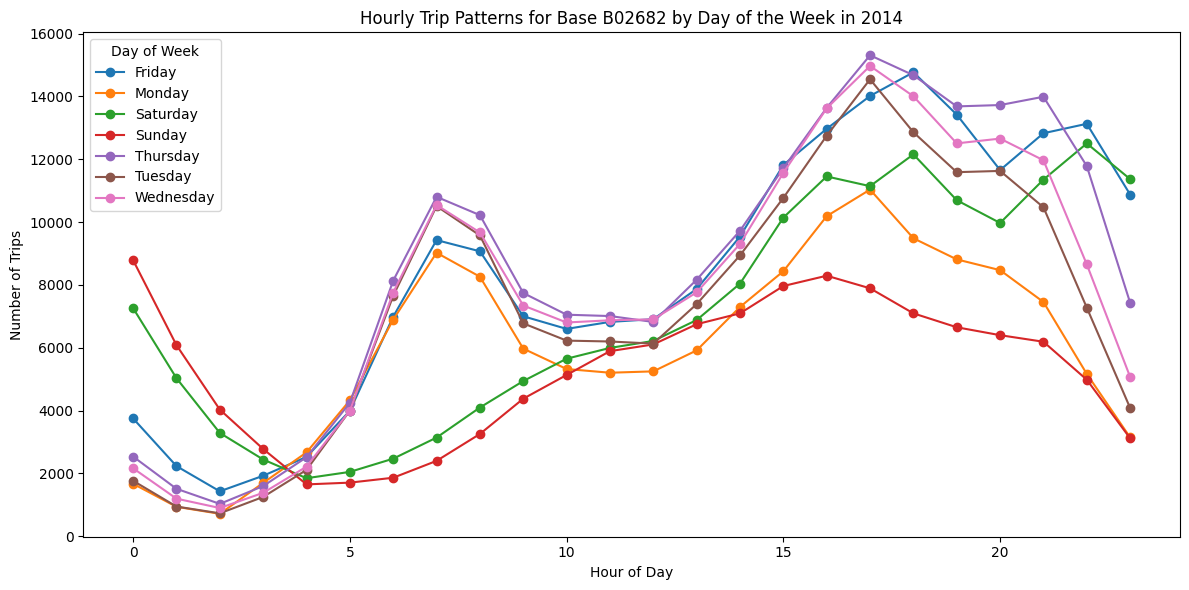

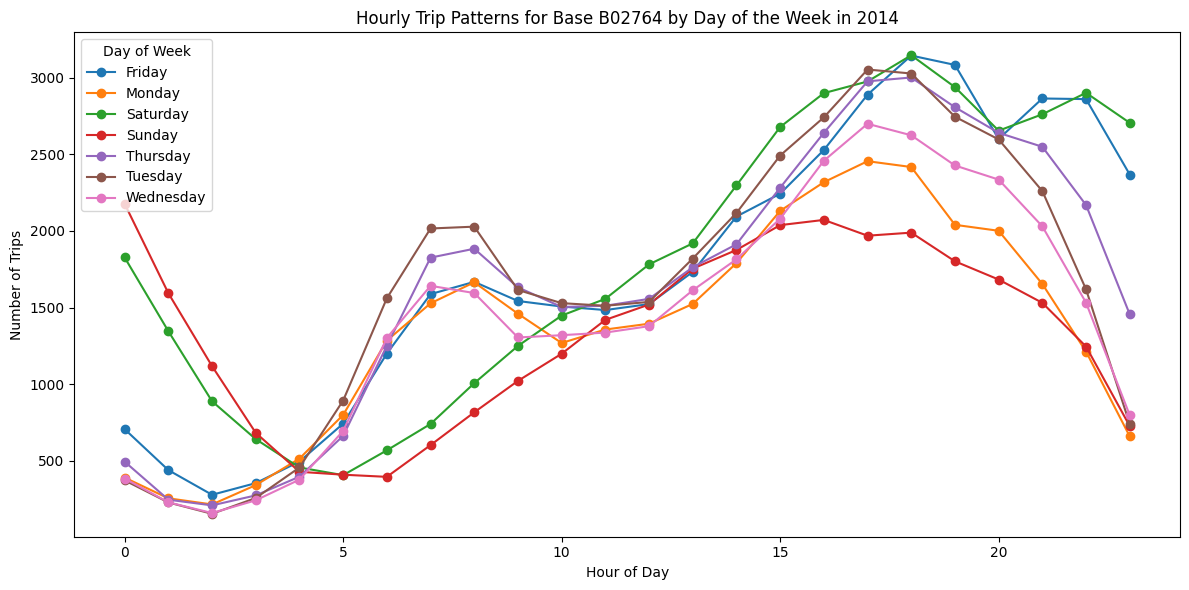

In [ ]:
bases = uber_2014_pickup_data['Base'].unique()

for base in bases:
    base_data = hourly_trips[hourly_trips['Base'] == base]
    plt.figure(figsize=(12, 6))

    for day in base_data['DayOfWeek'].unique():
        day_data = base_data[base_data['DayOfWeek'] == day]
        plt.plot(day_data['Hour'], day_data['TripCount'], marker='o', label=day)

    plt.title(f'Hourly Trip Patterns for Base {base} by Day of the Week in 2014')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trips')

    plt.legend(title='Day of Week', loc='upper left')

    plt.tight_layout()
    plt.show()




## 4.2 Average Hourly Profile Across Days

Compare average hourly shapes to see which days are structurally similar vs distinct.

In [ ]:
daily_hourly_trips = uber_2014_pickup_data.groupby(['Date', 'Hour'])['Base'].count().reset_index(name='TripCount')

daily_hourly_trips

,Date,Hour,TripCount
0,2014-04-01,0,138
1,2014-04-01,1,66
2,2014-04-01,2,53
3,2014-04-01,3,93
4,2014-04-01,4,166
...,...,...,...
4386,2014-09-30,18,2625
4387,2014-09-30,19,2404
4388,2014-09-30,20,2246
4389,2014-09-30,21,1961


In [ ]:
average_hourly_trips = daily_hourly_trips.groupby('Hour')['TripCount'].mean().reset_index()

average_hourly_trips

,Hour,TripCount
0,0,567.409836
1,1,367.360656
2,2,250.628415
3,3,263.863388
4,4,301.803279
5,5,458.683060
6,6,782.584699
7,7,1055.158470
8,8,1041.005464
9,9,874.136612


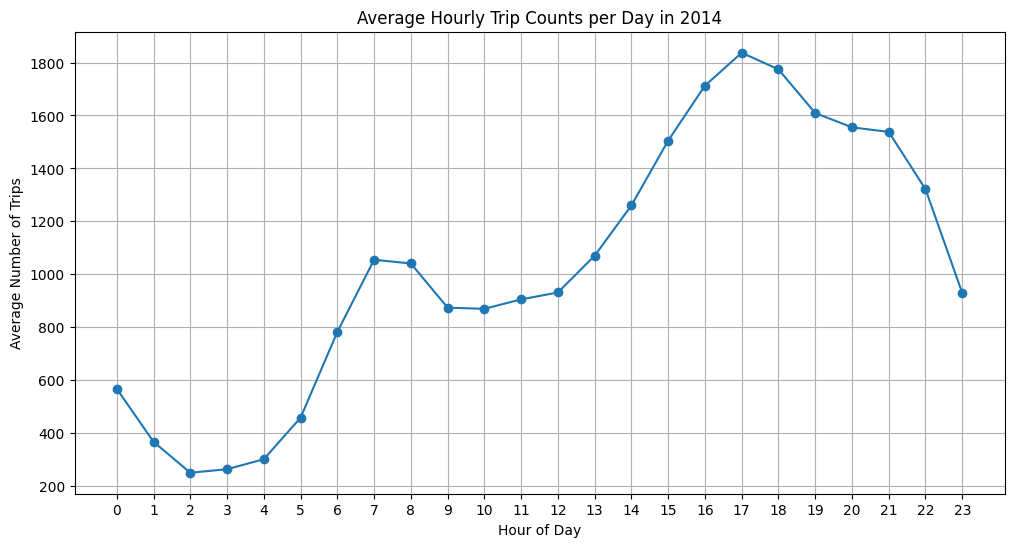

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(average_hourly_trips['Hour'], average_hourly_trips['TripCount'], marker='o')
plt.title('Average Hourly Trip Counts per Day in 2014')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## 4.3 Hourly Pattern Similarity (Correlation)

Use correlation of hourly vectors to group bases that behave similarly in time.

In [ ]:
daily_hourly_trips = uber_2014_pickup_data.groupby(['Date', 'Hour'])['Base'].count().reset_index(name='TripCount')
daily_hourly_trips.head(24)

,Date,Hour,TripCount
0,2014-04-01,0,138
1,2014-04-01,1,66
2,2014-04-01,2,53
3,2014-04-01,3,93
4,2014-04-01,4,166
5,2014-04-01,5,333
6,2014-04-01,6,722
7,2014-04-01,7,1001
8,2014-04-01,8,780
9,2014-04-01,9,532


In [ ]:
hourly_data = daily_hourly_trips.set_index(['Date', 'Hour']).unstack(level = 'Hour')

hourly_data.columns = [f'Hour_{int(hour)}' for hour in hourly_data.columns.get_level_values(1)]

hourly_data

,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,138.0,66.0,53.0,93.0,166.0,333.0,722.0,1001.0,780.0,532.0,...,736.0,967.0,1152.0,1262.0,1122.0,1018.0,597.0,878.0,529.0,317.0
2014-04-02,161.0,82.0,59.0,80.0,196.0,344.0,785.0,1099.0,927.0,656.0,...,868.0,1138.0,1313.0,1600.0,1252.0,1086.0,1143.0,994.0,638.0,348.0
2014-04-03,194.0,106.0,66.0,130.0,193.0,354.0,750.0,1022.0,864.0,591.0,...,934.0,1247.0,1438.0,1640.0,1628.0,1374.0,1591.0,1714.0,1580.0,793.0
2014-04-04,329.0,184.0,117.0,154.0,238.0,381.0,839.0,1202.0,1065.0,769.0,...,1190.0,1504.0,1865.0,2280.0,2449.0,2133.0,1489.0,1929.0,1859.0,1339.0
2014-04-05,723.0,416.0,215.0,181.0,153.0,177.0,206.0,279.0,340.0,450.0,...,704.0,1078.0,1313.0,1445.0,1575.0,1440.0,1348.0,1572.0,1830.0,1700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-26,606.0,346.0,239.0,340.0,406.0,684.0,1163.0,1525.0,1340.0,1232.0,...,1738.0,2038.0,2299.0,2626.0,3039.0,2782.0,2440.0,2686.0,2547.0,2355.0
2014-09-27,1686.0,1232.0,751.0,527.0,361.0,422.0,530.0,679.0,871.0,1091.0,...,1889.0,2230.0,2438.0,2562.0,2787.0,2683.0,2366.0,2863.0,2909.0,2710.0
2014-09-28,2087.0,1410.0,982.0,659.0,416.0,477.0,445.0,589.0,803.0,990.0,...,1760.0,1828.0,1937.0,1811.0,1800.0,1568.0,1415.0,1253.0,1009.0,621.0


In [ ]:
correlation_matrix = hourly_data.corr()

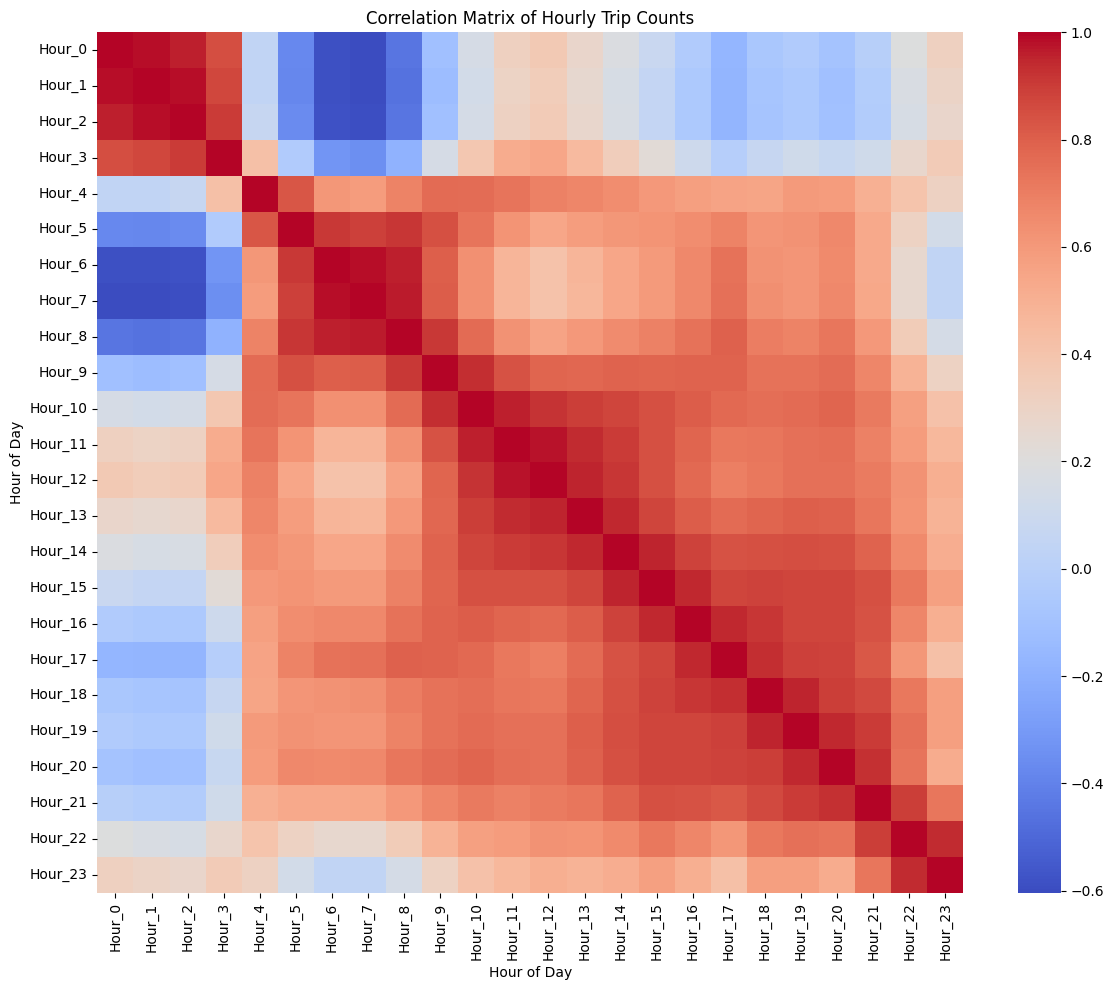

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Hourly Trip Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()


# **5. Demand Metrics and Explanatory Regression**

## 5.1 Trip Count EDA (Metrics + Distributions)

Summarize key statistics and distributions (daily totals, variability, peak-to-off-peak spread).

In [ ]:
uber_2014_pickup_data['Date'].min()

Timestamp('2014-04-01 00:00:00')

In [ ]:
daily_trips = uber_2014_pickup_data.groupby('Date')['Base'].count().reset_index(name = 'TripCount')
daily_trips

,Date,TripCount
0,2014-04-01,14546
1,2014-04-02,17474
2,2014-04-03,20701
3,2014-04-04,26714
4,2014-04-05,19521
...,...,...
178,2014-09-26,37504
179,2014-09-27,39468
180,2014-09-28,29656
181,2014-09-29,29201


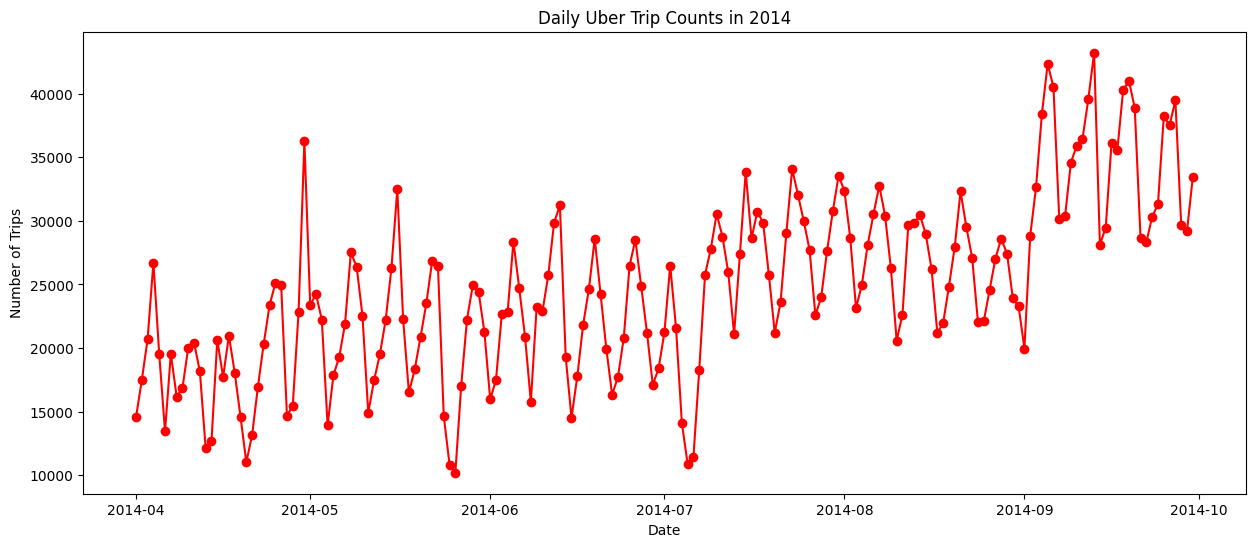

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(daily_trips['Date'], daily_trips['TripCount'], marker='o', linestyle='-', color = 'red')
plt.title('Daily Uber Trip Counts in 2014')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

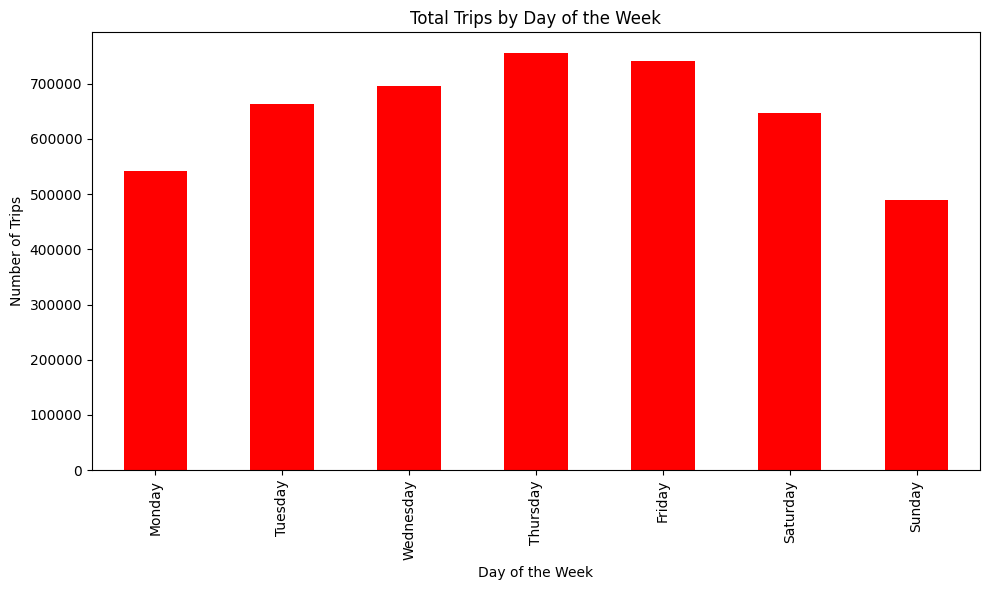

In [ ]:
daily_trips['DayOfWeek'] = daily_trips['Date'].dt.day_name()

trips_by_day = daily_trips.groupby('DayOfWeek')['TripCount'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']) #need to add reindex for better viz

trips_by_day.plot(kind='bar', figsize=(10,6), color = 'red')
plt.title('Total Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

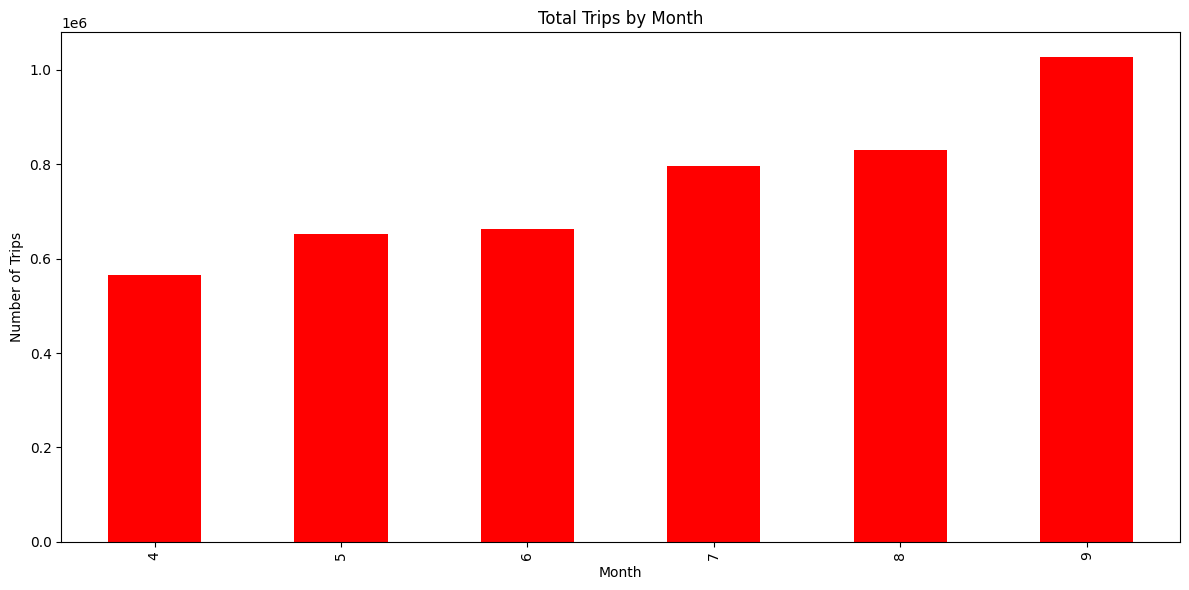

In [ ]:
daily_trips['Month'] = daily_trips['Date'].dt.month

trips_by_month = daily_trips.groupby('Month')['TripCount'].sum()
trips_by_month.plot(kind='bar', figsize=(12,6), color = 'red')
plt.title('Total Trips by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

In [ ]:
daily_trips

,Date,TripCount,DayOfWeek,Month
0,2014-04-01,14546,Tuesday,4
1,2014-04-02,17474,Wednesday,4
2,2014-04-03,20701,Thursday,4
3,2014-04-04,26714,Friday,4
4,2014-04-05,19521,Saturday,4
...,...,...,...,...
178,2014-09-26,37504,Friday,9
179,2014-09-27,39468,Saturday,9
180,2014-09-28,29656,Sunday,9
181,2014-09-29,29201,Monday,9


## 5.2 Regression Model (Encoding + Estimation)

Estimate a simple explanatory model using time controls (hour/day/month dummies) to quantify predictable patterns.

In [ ]:
# regression

day_dummies = pd.get_dummies(daily_trips['DayOfWeek'], drop_first=True)
month_dummies = pd.get_dummies(daily_trips['Month'], prefix='Month', drop_first=True)

daily_trips = pd.concat([daily_trips, day_dummies, month_dummies], axis=1)

daily_trips


,Date,TripCount,DayOfWeek,Month,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Month_5,Month_6,Month_7,Month_8,Month_9
0,2014-04-01,14546,Tuesday,4,False,False,False,False,True,False,False,False,False,False,False
1,2014-04-02,17474,Wednesday,4,False,False,False,False,False,True,False,False,False,False,False
2,2014-04-03,20701,Thursday,4,False,False,False,True,False,False,False,False,False,False,False
3,2014-04-04,26714,Friday,4,False,False,False,False,False,False,False,False,False,False,False
4,2014-04-05,19521,Saturday,4,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2014-09-26,37504,Friday,9,False,False,False,False,False,False,False,False,False,False,True
179,2014-09-27,39468,Saturday,9,False,True,False,False,False,False,False,False,False,False,True
180,2014-09-28,29656,Sunday,9,False,False,True,False,False,False,False,False,False,False,True
181,2014-09-29,29201,Monday,9,True,False,False,False,False,False,False,False,False,False,True


In [ ]:
dummy_cols = day_dummies.columns.tolist() + month_dummies.columns.tolist()

daily_trips[dummy_cols] = daily_trips[dummy_cols].astype(int)


In [ ]:
Y = daily_trips['TripCount']

X = daily_trips[dummy_cols]


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              TripCount   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     50.53
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           6.11e-48
Time:                        00:51:28   Log-Likelihood:                -1748.5
No. Observations:                 183   AIC:                             3521.
Df Residuals:                     171   BIC:                             3560.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.255e+04    915.019     24.645      0.0

## 5.3 Interpretation: Regression vs EDA
- Regression quantifies the EDA patterns: Friday baseline is highest; Monday/Sunday are materially lower; summer months add sizeable lift. R² ≈ 0.76 confirms time effects explain most variance.
- EDA shows the same seasonality and weekday shape visually (strong weekday peaks, summer bump), and highlights the late-day intraday plateau that the daily model abstracts away.
- Unexplained: non-time drivers (weather, events, pricing/surge, supply shifts, holidays) and spatial effects; residuals suggest remaining structure beyond simple time dummies.


# **6. Spatial Clustering and Hotspot Insights**

## 6.1 Normalize Features + Sweep K (Tuning)

Scale lat/lon, run clustering across K values, and compute diagnostics to choose a reasonable K.

In [ ]:
coords = uber_2014_pickup_data[['Lat', 'Lon']]
coords.head(5)

,Lat,Lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722


In [ ]:
scaler = StandardScaler()

norm_coords = scaler.fit_transform(coords)
norm_coords = pd.DataFrame(norm_coords, columns = ['Lat_norm', 'Lon_norm'])
norm_coords

,Lat_norm,Lon_norm
0,0.744413,0.316403
1,-0.314413,-1.073585
2,-0.191759,-0.249371
3,0.489094,-0.079988
4,0.504112,0.014308
...,...,...
4534322,0.689344,-0.200477
4534323,-1.205529,-3.567181
4534324,2.819512,0.718033
4534325,-0.779996,-0.586391


In [ ]:
#k-means

K_values = [2, 3, 5, 7, 9, 12, 16]

# dic to store cluster centers for each K
cluster_centers_dict = {}

for K in K_values:
  k_means = KMeans(n_clusters = K, random_state = 42)

  k_means.fit(norm_coords)

  stored_cluster_centers = pd.DataFrame(k_means.cluster_centers_, columns=['Lat_norm', 'Lon_norm'])

  # we have to bring it back to the original scale for interpretation and plotting purposes

  cluster_centers_original = scaler.inverse_transform(stored_cluster_centers)
  cluster_centers_original = pd.DataFrame(cluster_centers_original, columns=['Latitude', 'Longitude'])

  cluster_centers_dict[K] = cluster_centers_original

  uber_2014_pickup_data[f'Cluster_K{K}'] = k_means.labels_

## 6.2 Visualize Clusters (Folium Maps)

Map clusters to translate math into geography and spot meaningful pickup zones.

In [ ]:
import folium

map_center = [coords['Lat'].mean(), coords['Lon'].mean()]

for K in K_values:
    map_ = folium.Map(location=map_center, zoom_start=11)

    cluster_centers = cluster_centers_dict[K]

    for idx, row in cluster_centers.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f'Cluster {idx}',
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(map_)

    print(f"\nMap of Cluster Centers for K={K}")
    display(map_)



Map of Cluster Centers for K=2



Map of Cluster Centers for K=3



Map of Cluster Centers for K=5



Map of Cluster Centers for K=7



Map of Cluster Centers for K=9



Map of Cluster Centers for K=12



Map of Cluster Centers for K=16


## 6.3 Evaluate K Sensitivity (Impact + Tradeoffs)

Show how conclusions change as K changes (too few = over-merged, too many = noisy).

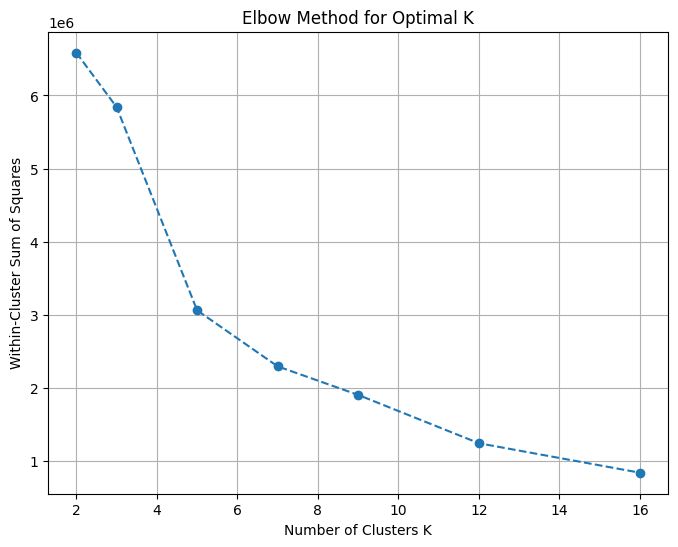

In [ ]:
inertia = []
for K in K_values:
    k_means = KMeans(n_clusters=K, random_state=42)
    k_means.fit(norm_coords)
    inertia.append(k_means.inertia_)

# elbow
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(K_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters K')
plt.ylabel('Within-Cluster Sum of Squares')
plt.grid(True)
plt.show()


Note: Ks around 6 balance compact clusters with geographic interpretability; visuals above illustrate the trade-offs.

## 6.4 Key Spatial Observations

Summarize what clusters reveal about demand concentration and the types of pickup environments.

- Hotspots are Manhattan-centric (Midtown/Downtown), reflecting dense commercial and transit corridors.
- Stable satellites appear at JFK/LGA and select outer-borough nodes, indicating airport and neighborhood feeder demand.
- Clusters stay compact; expanding K mostly splits Manhattan without adding new, actionable regions.

Summary note: K=6–7 keeps clusters cohesive and interpretable; use Manhattan cores for concentrated supply during peaks, maintain lighter coverage at airports/outer boroughs, and avoid over-splitting Manhattan, which would thin supply and lengthen ETAs.


# **7. Month-over-Month Hotspot Dynamics**

## 7.1 Monthly Clustering with Selected K

Run the same clustering approach by month to see whether hotspots persist, shift, or fragment over time.

In [ ]:
months = sorted(uber_2014_pickup_data['Month'].unique())

centroids_per_month = {}

for month in months:
  monthly_data = uber_2014_pickup_data[uber_2014_pickup_data['Month'] == month]

  coords = monthly_data[['Lat', 'Lon']]

  scaler = StandardScaler()
  norm_coords = scaler.fit_transform(coords)

  k_means = KMeans(n_clusters=7, random_state=42) # my optinal num of clusters was 7
  k_means.fit(norm_coords)

  normalized_cluster_centers = k_means.cluster_centers_

  cluster_centers = scaler.inverse_transform(normalized_cluster_centers)

  cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Latitude', 'Longitude'])

  cluster_centers_df['Month'] = month

  centroids_per_month[month] = cluster_centers_df

  monthly_data[f'Cluster_Month_{month}'] = k_means.labels_

  uber_2014_pickup_data.loc[monthly_data.index, f'Cluster_Month_{month}'] = k_means.labels_

centroids_per_month_df = pd.concat(centroids_per_month.values(), ignore_index=True)

print(centroids_per_month_df.head())

    Latitude  Longitude  Month
0  40.729755 -73.996882      4
1  40.764413 -73.974767      4
2  40.657175 -73.777742      4
3  40.683250 -73.967244      4
4  41.011553 -73.688840      4


In [ ]:
centroids_per_month_df

# centroids_per_month_df.to_csv(os.path.join(data_path, 'centroids_per_month.csv'))

,Latitude,Longitude,Month
0,40.729755,-73.996882,4
1,40.764413,-73.974767,4
2,40.657175,-73.777742,4
3,40.683250,-73.967244,4
4,41.011553,-73.688840,4
5,40.791650,-73.886783,4
6,40.699442,-74.202480,4
7,40.679696,-73.966438,5
8,40.764623,-73.974879,5
9,40.657201,-73.776574,5


In [ ]:
uber_2014_pickup_data.tail(10)

# uber_2014_pickup_data.to_csv(os.path.join(data_path, 'uber_2014_pickups_with_clusters.csv'))

,Date/Time,Lat,Lon,Base,Date,Time,Month,Week,DayOfMonthNum,DayOfWeekNum,...,Cluster_K7,Cluster_K9,Cluster_K12,Cluster_K16,Cluster_Month_4,Cluster_Month_5,Cluster_Month_6,Cluster_Month_7,Cluster_Month_8,Cluster_Month_9
4534317,2014-09-30 22:56:00,40.7371,-74.0289,B02764,2014-09-30,22:56:00,9,40,30,1,...,3,3,3,3,NaN,NaN,NaN,NaN,NaN,4.0
4534318,2014-09-30 22:56:00,40.6446,-73.7823,B02764,2014-09-30,22:56:00,9,40,30,1,...,0,6,6,6,NaN,NaN,NaN,NaN,NaN,2.0
4534319,2014-09-30 22:56:00,40.7163,-73.9623,B02764,2014-09-30,22:56:00,9,40,30,1,...,3,0,0,0,NaN,NaN,NaN,NaN,NaN,4.0
4534320,2014-09-30 22:57:00,40.6979,-73.9365,B02764,2014-09-30,22:57:00,9,40,30,1,...,6,0,0,0,NaN,NaN,NaN,NaN,NaN,1.0
4534321,2014-09-30 22:57:00,40.7300,-73.9565,B02764,2014-09-30,22:57:00,9,40,30,1,...,3,0,0,0,NaN,NaN,NaN,NaN,NaN,4.0
4534322,2014-09-30 22:57:00,40.7668,-73.9845,B02764,2014-09-30,22:57:00,9,40,30,1,...,1,1,1,1,NaN,NaN,NaN,NaN,NaN,0.0
4534323,2014-09-30 22:57:00,40.6911,-74.1773,B02764,2014-09-30,22:57:00,9,40,30,1,...,2,8,8,8,NaN,NaN,NaN,NaN,NaN,3.0
4534324,2014-09-30 22:58:00,40.8519,-73.9319,B02764,2014-09-30,22:58:00,9,40,30,1,...,4,2,9,2,NaN,NaN,NaN,NaN,NaN,5.0
4534325,2014-09-30 22:58:00,40.7081,-74.0066,B02764,2014-09-30,22:58:00,9,40,30,1,...,3,3,3,12,NaN,NaN,NaN,NaN,NaN,4.0
4534326,2014-09-30 22:58:00,40.7140,-73.9496,B02764,2014-09-30,22:58:00,9,40,30,1,...,3,0,0,0,NaN,NaN,NaN,NaN,NaN,4.0


# **8. Conclusion**


## 8.1 Key Findings
- Demand is highly concentrated in two major bases, showing a centralized supply network with a long tail of smaller bases.
- Weekday commuter demand dominates; weekends contribute roughly a quarter of trips, so utilization hinges on weekday flows.
- Intraday shape is predictable: overnight trough, morning ramp, and a sustained late-day peak (commute-to-evening window) that should anchor staffing and positioning.
- Time-dummy regression confirms strong temporal drivers: Mondays and Sundays are well below Friday, while summer months add substantial volume, quantifying weekday/seasonality effects.
- Clustering settles around 6–7 stable hotspots centered on Manhattan with recurring airport/outer-borough satellites, indicating durable, dense pickup nodes.

## 8.2 Limitations
- Pickup-only: no dropoff locations/times, so no OD flows, trip lengths/durations, or completion rates.
- No fares, surge, or driver supply/availability; cannot study revenue, pricing response, or matching efficiency.
- No wait/cancel metrics; rider experience and service level cannot be inferred.
- No rider/driver attributes, weather, holidays/events, or competitive (taxi/other) context, so many effects may be confounded.
